---

1. Take an image and apply Fourier Transform on it. Display original, Transformed and inverse transformed image.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

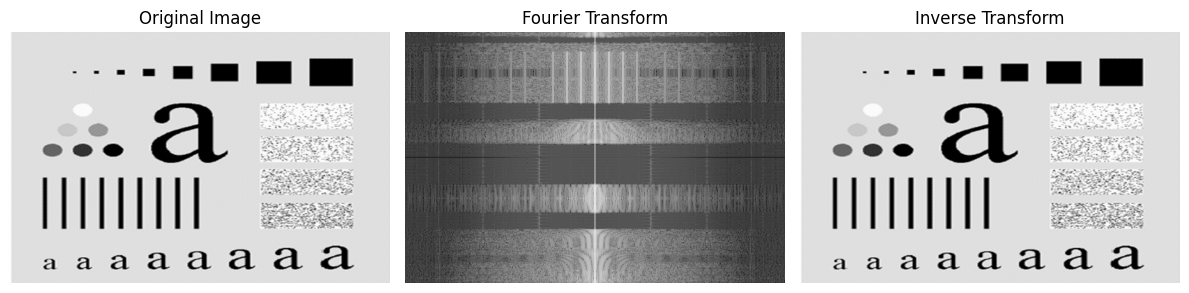

In [3]:
img = tf.keras.utils.load_img("test_img.png")
img = tf.image.rgb_to_grayscale(img)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)  # Shift the zero frequency to center

# 3. Compute the magnitude spectrum (log scale for better visibility)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

# 4. Apply Inverse Fourier Transform
f_ishift = np.fft.ifftshift(fshift)  # Shift back
img_back = np.fft.ifft2(f_ishift)  # Inverse FFT
img_back = np.abs(img_back)  # Take magnitude

# 5. Plot original, transformed and inverse-transformed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fourier Transform")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Inverse Transform")
plt.imshow(img_back, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

2. Perform image smoothing on an image using
- Ideal Low pass filter (Use different cut off frequency D0=5, 15, 30, 80 )
- Butterworth Low pass filter (same cut off frequency) of Order 2 and Order 4
- Gaussian Low pass filter (same cut-off frequency)   

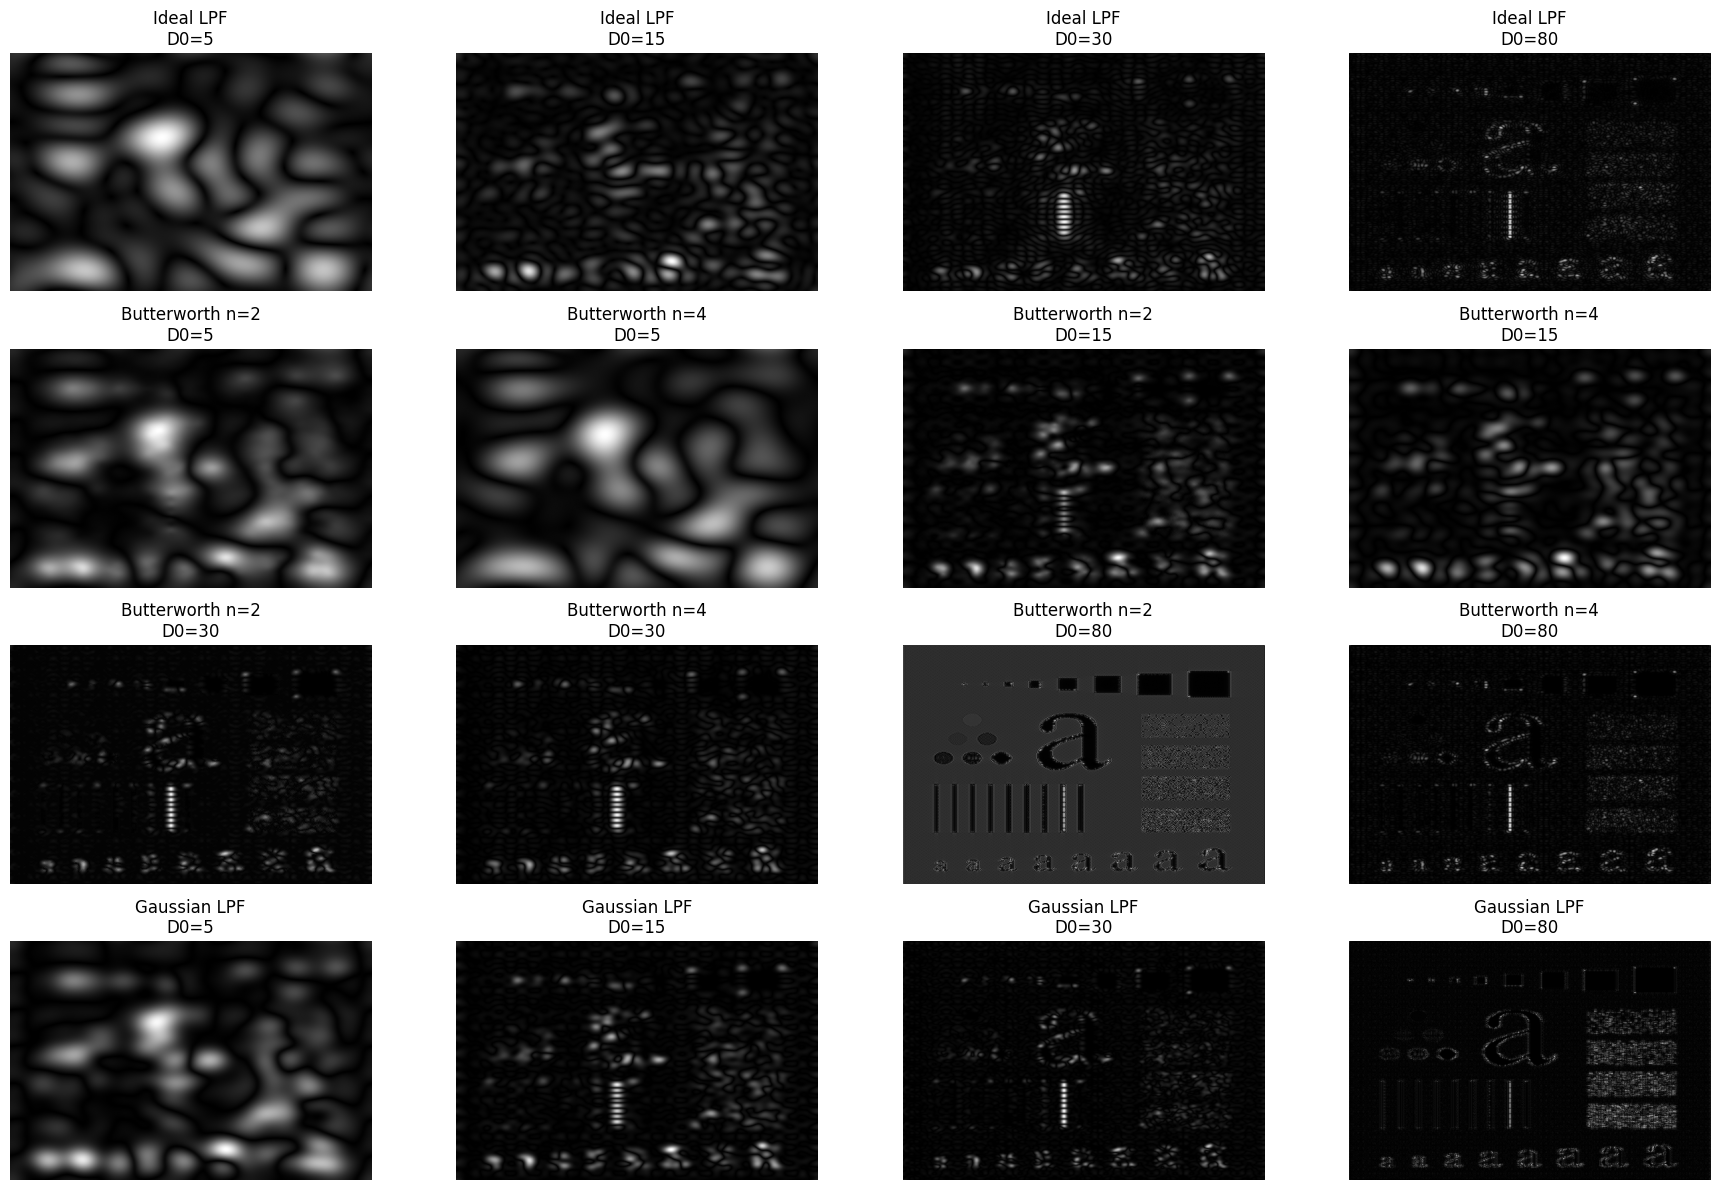

In [9]:
def load_grayscale_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return tf.squeeze(image).numpy()

def distance_matrix(shape):
    M, N = shape
    u = np.arange(M)
    v = np.arange(N)
    u[u > M//2] -= M
    v[v > N//2] -= N
    V, U = np.meshgrid(v, u)
    return np.sqrt(U**2 + V**2)

def ideal_lpf(shape, D0):
    return (distance_matrix(shape) <= D0).astype(np.float32)

def butterworth_lpf(shape, D0, n):
    D = distance_matrix(shape)
    return 1 / (1 + (D / D0)**(2 * n))

def gaussian_lpf(shape, D0):
    D = distance_matrix(shape)
    return np.exp(-(D**2) / (2 * D0**2))

def apply_filter(img, filter_mask):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    filtered = dft_shift * filter_mask
    return np.abs(np.fft.ifft2(np.fft.ifftshift(filtered)))

def show_all_results(img, D0_values, orders=[2, 4]):
    plt.figure(figsize=(18, 12))
    idx = 1

    for D0 in D0_values:
        mask = ideal_lpf(img.shape, D0)
        result = apply_filter(img, mask)
        plt.subplot(4, len(D0_values), idx)
        plt.imshow(result, cmap='gray')
        plt.title(f'Ideal LPF\nD0={D0}')
        plt.axis('off')
        idx += 1

    for D0 in D0_values:
        for order in orders:
            mask = butterworth_lpf(img.shape, D0, order)
            result = apply_filter(img, mask)
            plt.subplot(4, len(D0_values), idx)
            plt.imshow(result, cmap='gray')
            plt.title(f'Butterworth n={order}\nD0={D0}')
            plt.axis('off')
            idx += 1

    for D0 in D0_values:
        mask = gaussian_lpf(img.shape, D0)
        result = apply_filter(img, mask)
        plt.subplot(4, len(D0_values), idx)
        plt.imshow(result, cmap='gray')
        plt.title(f'Gaussian LPF\nD0={D0}')
        plt.axis('off')
        idx += 1

    plt.tight_layout()
    plt.show()

image_path = "test_img.png" 
image = load_grayscale_image(image_path)
cutoffs = [5, 15, 30, 80]
show_all_results(image, cutoffs)


3. Perform image sharpening on an image using
- Ideal High pass filter (Use different cut off frequency D0= 15, 30, 80 )
- Butterworth High pass filter of order 2 and order 4
- Gaussian High pass filter (same cut-off frequency)

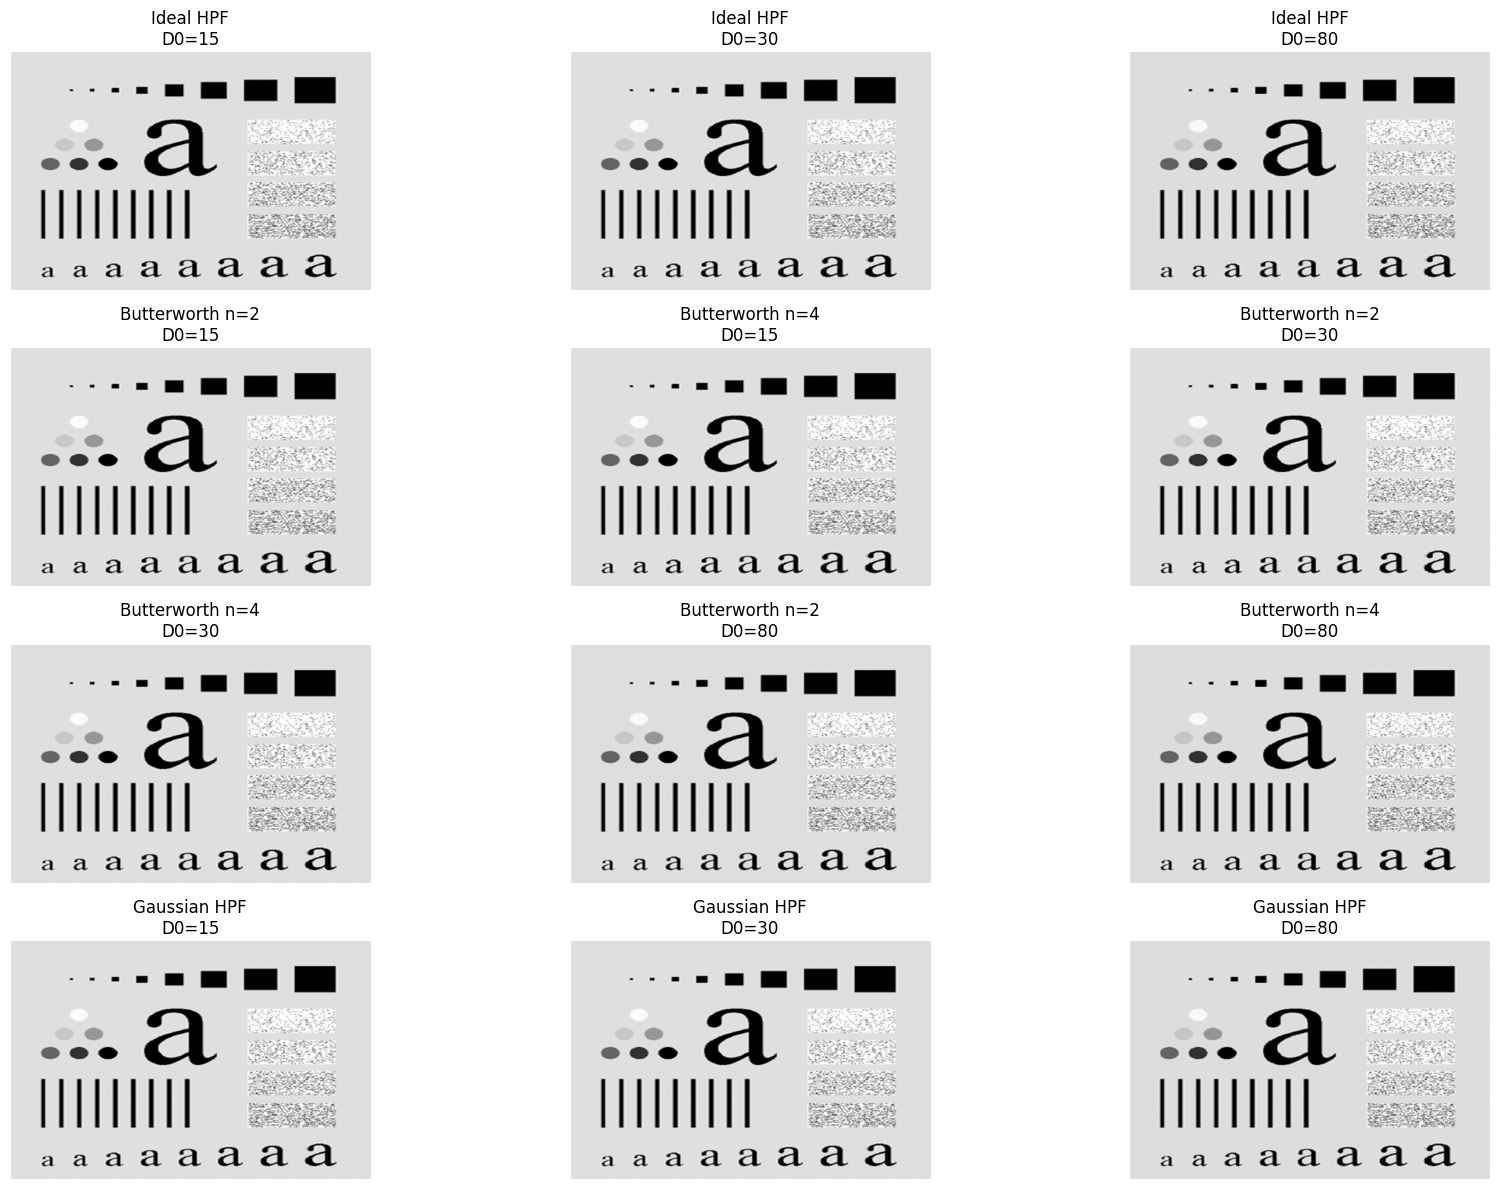

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
def load_grayscale_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return tf.squeeze(image).numpy()

# Distance matrix
def distance_matrix(shape):
    M, N = shape
    u = np.arange(M)
    v = np.arange(N)
    u[u > M//2] -= M
    v[v > N//2] -= N
    V, U = np.meshgrid(v, u)
    return np.sqrt(U**2 + V**2)

# High pass filters
def ideal_hpf(shape, D0):
    return 1 - (distance_matrix(shape) <= D0).astype(np.float32)

def butterworth_hpf(shape, D0, n):
    D = distance_matrix(shape)
    return 1 / (1 + (D0 / (D + 1e-5))**(2 * n))  # +1e-5 avoids divide by zero

def gaussian_hpf(shape, D0):
    D = distance_matrix(shape)
    return 1 - np.exp(-(D**2) / (2 * D0**2))

# Apply frequency filter
def apply_filter(img, filter_mask):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    filtered = dft_shift * filter_mask
    result = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered)))
    return result

# Show results
def show_sharpened_results(img, D0_values, orders=[2, 4]):
    plt.figure(figsize=(18, 12))
    idx = 1

    for D0 in D0_values:
        mask = ideal_hpf(img.shape, D0)
        result = apply_filter(img, mask)
        plt.subplot(4, len(D0_values), idx)
        plt.imshow(result, cmap='gray')
        plt.title(f'Ideal HPF\nD0={D0}')
        plt.axis('off')
        idx += 1

    for D0 in D0_values:
        for order in orders:
            mask = butterworth_hpf(img.shape, D0, order)
            result = apply_filter(img, mask)
            plt.subplot(4, len(D0_values), idx)
            plt.imshow(result, cmap='gray')
            plt.title(f'Butterworth n={order}\nD0={D0}')
            plt.axis('off')
            idx += 1

    for D0 in D0_values:
        mask = gaussian_hpf(img.shape, D0)
        result = apply_filter(img, mask)
        plt.subplot(4, len(D0_values), idx)
        plt.imshow(result, cmap='gray')
        plt.title(f'Gaussian HPF\nD0={D0}')
        plt.axis('off')
        idx += 1

    plt.tight_layout()
    plt.show()

# === MAIN ===
image_path = 'test_img.png'  # Replace with your image path
image = load_grayscale_image(image_path)
cutoffs = [15, 30, 80]
show_sharpened_results(image, cutoffs)


4. Write a program to perform the Huffman coding and decoding techniques on an image and compute Compression Ratio.

Huffman Coding Complete!
Original Image Size: 1569600 bits
Compressed Size: 815931 bits
Compression Ratio: 1.92


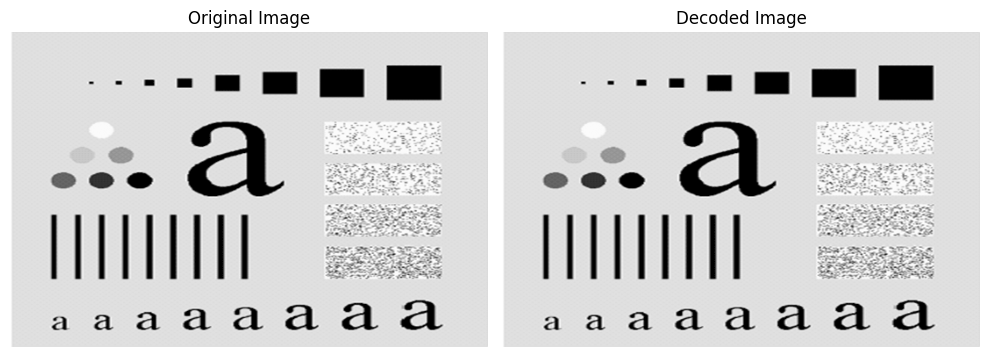

In [12]:
import tensorflow as tf
import numpy as np
import heapq
from collections import defaultdict
import matplotlib.pyplot as plt

# Huffman Tree Node
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):  # required for heapq
        return self.freq < other.freq

# Build Huffman Tree
def build_huffman_tree(freq_dict):
    heap = [Node(sym, freq) for sym, freq in freq_dict.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0]  # root node

# Generate Huffman Codes
def generate_codes(node, prefix="", code_dict=None):
    if code_dict is None:
        code_dict = {}
    if node is not None:
        if node.symbol is not None:
            code_dict[node.symbol] = prefix
        generate_codes(node.left, prefix + "0", code_dict)
        generate_codes(node.right, prefix + "1", code_dict)
    return code_dict

# Encode Image
def huffman_encode(img, codes):
    flat = img.flatten()
    encoded = ''.join(codes[p] for p in flat)
    return encoded

# Decode Huffman Bitstring
def huffman_decode(bitstring, root, shape):
    decoded = []
    node = root
    for bit in bitstring:
        node = node.left if bit == '0' else node.right
        if node.symbol is not None:
            decoded.append(node.symbol)
            node = root
    return np.array(decoded, dtype=np.uint8).reshape(shape)

# Load grayscale image using TensorFlow
def load_grayscale_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.uint8)
    return tf.squeeze(image).numpy()

# Compute compression ratio
def compute_compression_ratio(original_shape, encoded_bits):
    original_bits = original_shape[0] * original_shape[1] * 8  # 8 bits per pixel
    compressed_bits = len(encoded_bits)
    ratio = original_bits / compressed_bits
    return ratio

# === MAIN ===
image_path = 'test_img.png'  # Replace with your grayscale image
img = load_grayscale_image(image_path)

# 1. Frequency count
values, counts = np.unique(img, return_counts=True)
freq_dict = dict(zip(values, counts))

# 2. Build tree and generate codes
tree_root = build_huffman_tree(freq_dict)
codes = generate_codes(tree_root)

# 3. Encode image
encoded_data = huffman_encode(img, codes)

# 4. Decode to verify correctness
decoded_img = huffman_decode(encoded_data, tree_root, img.shape)

# 5. Compute Compression Ratio
compression_ratio = compute_compression_ratio(img.shape, encoded_data)

# === Display ===
print(f"Huffman Coding Complete!")
print(f"Original Image Size: {img.shape[0]*img.shape[1]*8} bits")
print(f"Compressed Size: {len(encoded_data)} bits")
print(f"Compression Ratio: {compression_ratio:.2f}")

# Optional: Show original and reconstructed image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(decoded_img, cmap='gray')
plt.title("Decoded Image")
plt.axis('off')
plt.tight_layout()
plt.show()


5. Write a program to perform the Arithmetic coding and decoding techniques on an image and compute Compression Ratio.

Arithmetic Coding Complete!
Encoded Decimal Value: 0.999838032155516814409980661982975884998646958667971828223281712108249245123680046733914806842401051
Compression Ratio: 15854.55


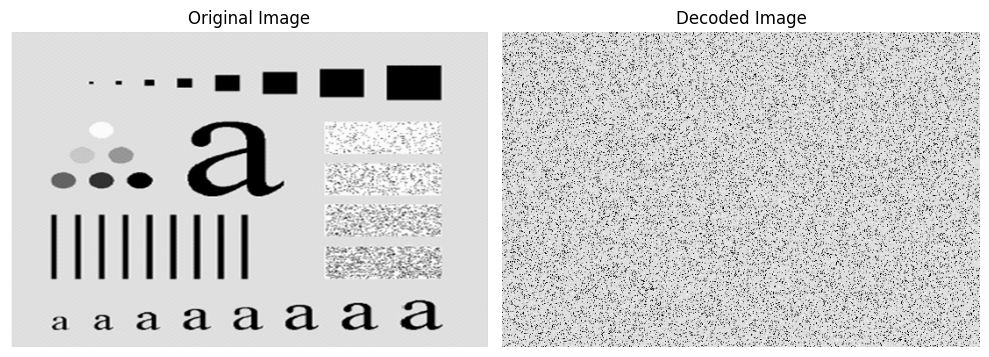

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from collections import defaultdict

# Set high precision for Decimal arithmetic
getcontext().prec = 100

# Load grayscale image
def load_grayscale_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.uint8)
    return tf.squeeze(image).numpy()

# Calculate probability and cumulative intervals
def get_probabilities(image):
    flat = image.flatten()
    total = len(flat)
    freq = defaultdict(int)
    for pixel in flat:
        freq[pixel] += 1

    symbols = sorted(freq.keys())
    prob = {s: Decimal(freq[s]) / Decimal(total) for s in symbols}
    
    # CDF (cumulative distribution function)
    cdf = {}
    cumulative = Decimal(0)
    for s in symbols:
        cdf[s] = (cumulative, cumulative + prob[s])
        cumulative += prob[s]
    
    return prob, cdf, symbols

# Arithmetic Encoding
def arithmetic_encode(image, cdf):
    flat = image.flatten()
    low = Decimal(0)
    high = Decimal(1)

    for symbol in flat:
        range_ = high - low
        sym_low, sym_high = cdf[symbol]
        high = low + range_ * sym_high
        low = low + range_ * sym_low

    return (low + high) / 2  # encoded number

# Arithmetic Decoding
def arithmetic_decode(encoded_value, cdf, total_symbols):
    decoded = []
    inv_cdf = {v: k for k, v in enumerate(cdf.keys())}
    sorted_items = list(cdf.items())

    for _ in range(total_symbols):
        for symbol, (sym_low, sym_high) in sorted_items:
            if sym_low <= encoded_value < sym_high:
                decoded.append(symbol)
                range_ = sym_high - sym_low
                encoded_value = (encoded_value - sym_low) / range_
                break
    return np.array(decoded, dtype=np.uint8)

# Compression Ratio
def compute_compression_ratio(original_shape, encoded_value):
    original_bits = original_shape[0] * original_shape[1] * 8
    encoded_bits = encoded_value.adjusted() + getcontext().prec  # log2 approximation
    return original_bits / encoded_bits

# === MAIN ===
image_path = 'test_img.png'  # Replace with your grayscale image
image = load_grayscale_image(image_path)
prob, cdf, symbols = get_probabilities(image)

# Encode
encoded_value = arithmetic_encode(image, cdf)

# Decode
decoded_array = arithmetic_decode(encoded_value, cdf, image.size).reshape(image.shape)

# Compression Ratio
compression_ratio = compute_compression_ratio(image.shape, encoded_value)

# === Display Results ===
print(f"Arithmetic Coding Complete!")
print(f"Encoded Decimal Value: {encoded_value}")
print(f"Compression Ratio: {compression_ratio:.2f}")

# Optional Visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(decoded_array, cmap='gray')
plt.title("Decoded Image")
plt.axis('off')
plt.tight_layout()
plt.show()


6. Take an image and apply Discrete Cosine transformation on it. Display original, Transformed and inverse transformed image.

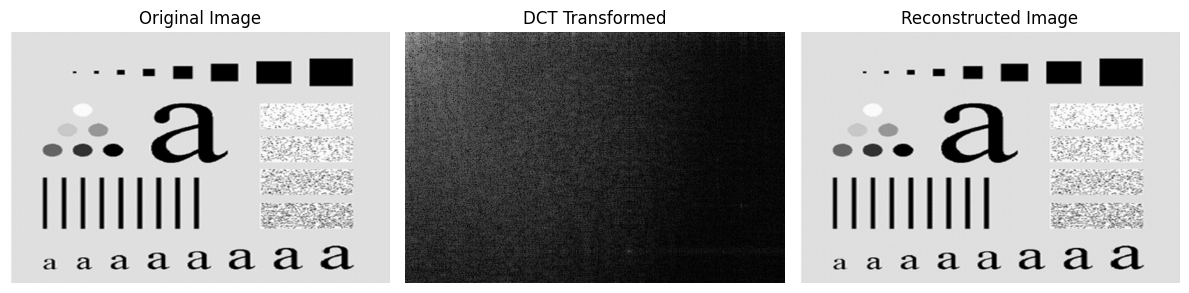

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Load grayscale image using TensorFlow
def load_grayscale_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.uint8)
    return tf.squeeze(image).numpy()

# 2D DCT (Type-II)
def dct2(img):
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

# 2D Inverse DCT (Type-III)
def idct2(dct_img):
    return idct(idct(dct_img.T, norm='ortho').T, norm='ortho')

# === MAIN ===
image_path = 'test_img.png'  # Replace with your grayscale image path
image = load_grayscale_image(image_path).astype(np.float32)

# Apply DCT and Inverse DCT
dct_transformed = dct2(image)
reconstructed = idct2(dct_transformed)

# === Display Results ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.log(abs(dct_transformed) + 1), cmap='gray')  # log scale for better visibility
plt.title("DCT Transformed")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.clip(reconstructed, 0, 255).astype(np.uint8), cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


7. Take an image, apply Discrete Cosine transformation, quantize data and apply Huffman coding. Apply Huffman decoding and inverse Discrete Cosine Transform to obtain reconstructed image. Calculate Compression Ratio and PSNR. (use different quantization value and analyze reconstructed image quality.)

Quantization Value: 5
Compression Ratio: 3.71
PSNR: 46.90 dB


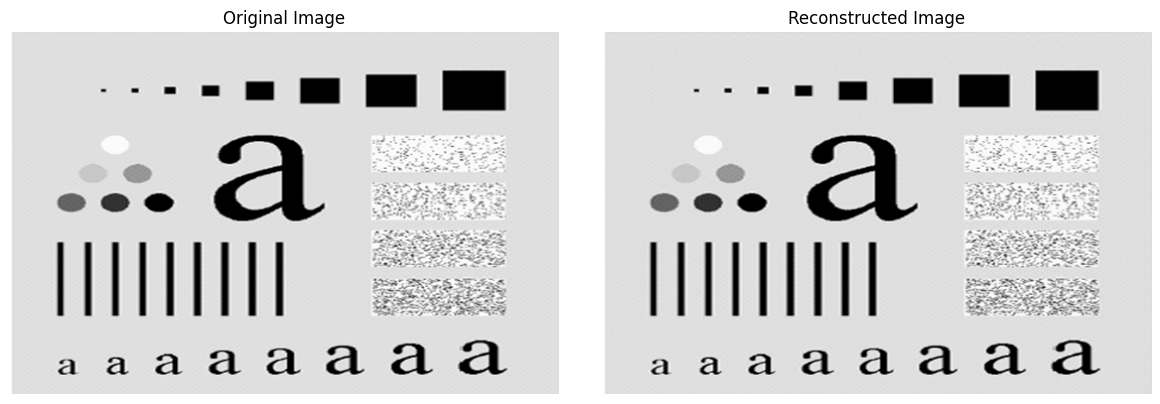

Quantization Value: 10
Compression Ratio: 4.55
PSNR: 42.77 dB


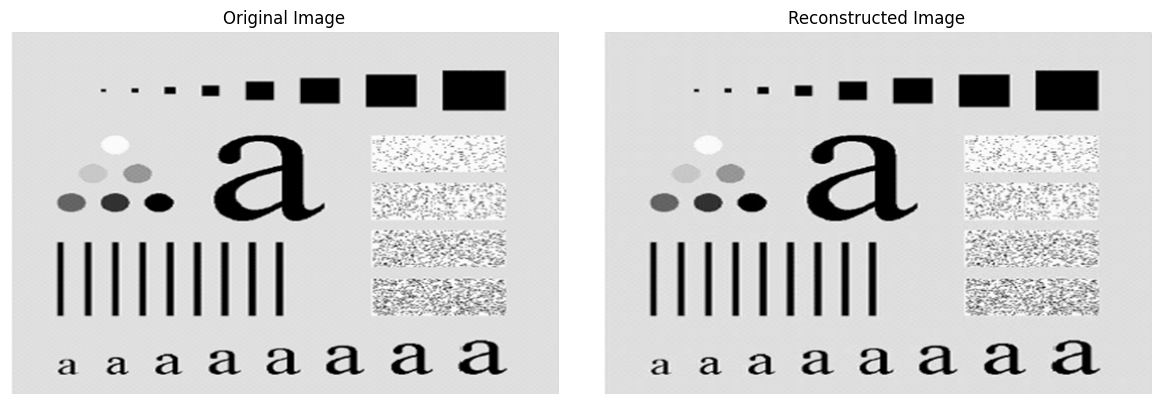

Quantization Value: 20
Compression Ratio: 5.37
PSNR: 39.30 dB


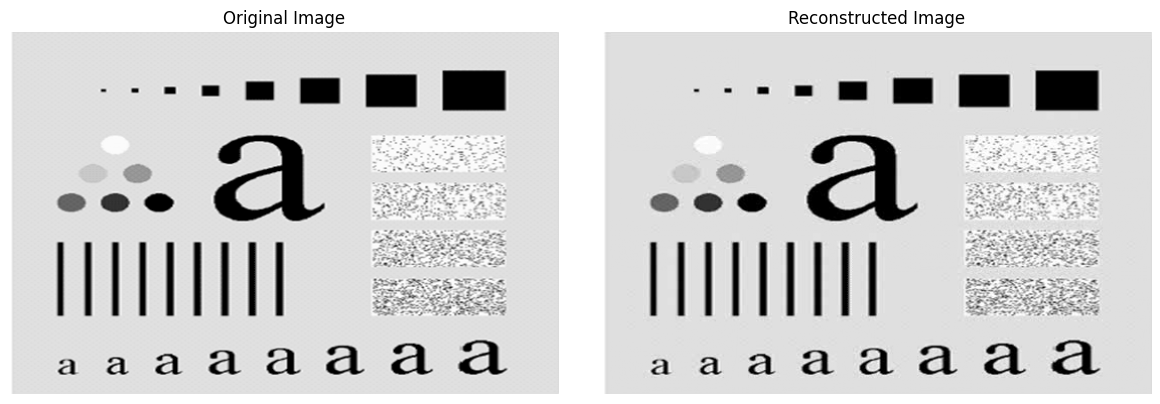

Quantization Value: 50
Compression Ratio: 6.37
PSNR: 32.93 dB


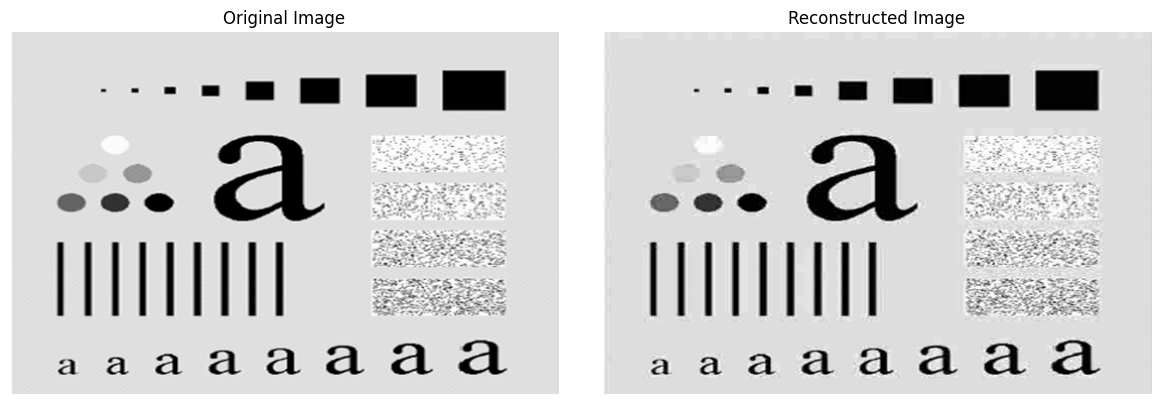

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from collections import defaultdict
import heapq
import math

# Load grayscale image
def load_grayscale_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.uint8)
    return tf.squeeze(image).numpy()

# 2D DCT and inverse DCT
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Quantization
def quantize(block, q):
    return np.round(block / q).astype(np.int32)

def dequantize(block, q):
    return (block * q).astype(np.float32)

# Huffman Tree
class Node:
    def __init__(self, sym, freq):
        self.sym = sym
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq):
    heap = [Node(k, v) for k, v in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        merged = Node(None, a.freq + b.freq)
        merged.left = a
        merged.right = b
        heapq.heappush(heap, merged)
    return heap[0]

def generate_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}
    if node.sym is not None:
        codebook[node.sym] = prefix
    else:
        generate_codes(node.left, prefix + '0', codebook)
        generate_codes(node.right, prefix + '1', codebook)
    return codebook

def huffman_encode(data, codebook):
    return ''.join(codebook[sym] for sym in data)

def huffman_decode(encoded, tree, total_symbols):
    node = tree
    decoded = []
    for bit in encoded:
        node = node.left if bit == '0' else node.right
        if node.sym is not None:
            decoded.append(node.sym)
            node = tree
        if len(decoded) == total_symbols:
            break
    return decoded

# PSNR Calculation
def compute_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

# === MAIN ===
def jpeg_like_pipeline(image_path, quant_value=10):
    block_size = 8
    img = load_grayscale_image(image_path).astype(np.float32)
    h, w = img.shape
    h_pad = (block_size - h % block_size) % block_size
    w_pad = (block_size - w % block_size) % block_size
    img_padded = np.pad(img, ((0, h_pad), (0, w_pad)), mode='constant')

    h_blocks, w_blocks = img_padded.shape[0] // 8, img_padded.shape[1] // 8
    quantized_blocks = []

    # DCT and Quantization
    for i in range(0, img_padded.shape[0], block_size):
        for j in range(0, img_padded.shape[1], block_size):
            block = img_padded[i:i+block_size, j:j+block_size]
            dct_block = dct2(block - 128)
            quant_block = quantize(dct_block, quant_value)
            quantized_blocks.append(quant_block.flatten())

    all_symbols = np.concatenate(quantized_blocks)
    freq = defaultdict(int)
    for val in all_symbols:
        freq[val] += 1

    # Huffman Coding
    tree = build_huffman_tree(freq)
    codes = generate_codes(tree)
    encoded = huffman_encode(all_symbols, codes)

    # Huffman Decoding
    decoded_symbols = huffman_decode(encoded, tree, len(all_symbols))
    decoded_blocks = [np.array(decoded_symbols[i:i+64]).reshape(8, 8)
                      for i in range(0, len(decoded_symbols), 64)]

    # Inverse DCT and Reconstruction
    rec_img = np.zeros_like(img_padded)
    k = 0
    for i in range(0, img_padded.shape[0], block_size):
        for j in range(0, img_padded.shape[1], block_size):
            deq = dequantize(decoded_blocks[k], quant_value)
            block = idct2(deq) + 128
            rec_img[i:i+8, j:j+8] = np.clip(block, 0, 255)
            k += 1

    rec_img = rec_img[:h, :w].astype(np.uint8)

    # Compression Ratio
    original_bits = img.shape[0] * img.shape[1] * 8
    compressed_bits = len(encoded)
    compression_ratio = original_bits / compressed_bits
    psnr = compute_psnr(img[:h, :w], rec_img)

    # Display Results
    print(f"Quantization Value: {quant_value}")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"PSNR: {psnr:.2f} dB")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rec_img, cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# === Try different quantization values ===
jpeg_like_pipeline("test_img.png", quant_value=5)
jpeg_like_pipeline("test_img.png", quant_value=10)
jpeg_like_pipeline("test_img.png", quant_value=20)
jpeg_like_pipeline("test_img.png", quant_value=50)
